# Introuducción

Este dataset fue creado y donado por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando (experimentalmente) ciclos sucesivos de 60 segundos de duración sobre un Rig Hidráulico. 

El Rig consiste en un circuito primario de trabajo, y un circuito secundario de enfriamiento que se conectan a traves de un tanque de aceite. 

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

A la par que se medían diferentes señales de procesos (inputs del dataset) se "variaba" la condición de "salud" de diferentes componentes fundamentales para el rig. El objetivo es poder predecir el estado / condición de esos componentes a partir de las señales de proceso.



Componentes:
* Enfriador. 3 clases: Eficiencia optima, eficiencia reducida, riesgo de falla total.
* Valvula. 4 clases: comportamiento de apertura y cierre optimo, retraso / atascamiento leve, retraso severo, riesgo de falla total.
* Fugas internas en bomba. 3 clases: sin fugas, pequeñas fugas, fugas severas.
* Presión en acumulador hidráulico. 4 clases: presión óptima, presión levemente reducida, presión severamente reducida, cercano a falla total.


In [18]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
path = './dataset/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

with open(path + 'df_output_structured.pkl','rb') as file:
    df_y=pkl.load(file)

In [4]:
df_y=df_y[np.array(df_y.dtype.names)[:-1]]

In [5]:
# Relleno NaN con valores interpolados
for col in df_x.dtype.names:
    aux = pd.DataFrame(df_x[col].transpose()) 
    aux = aux.interpolate()
    aux = np.array(aux).transpose()
    df_x[col] = aux

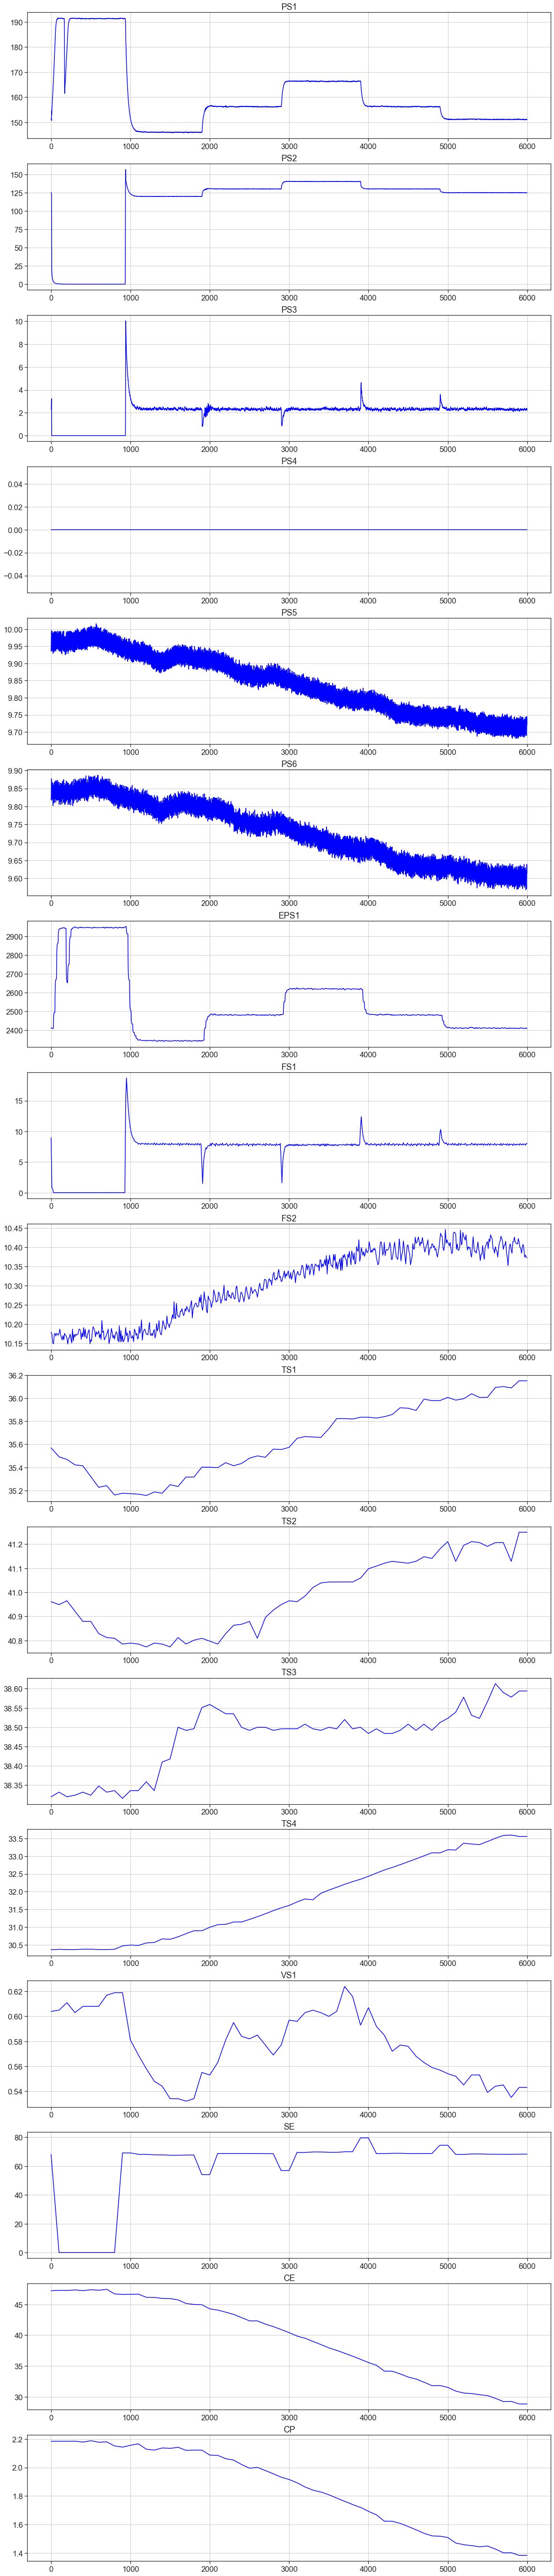

In [25]:
# Grafico de señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

In [6]:
x_train, x_test, y_train, y_test = train_test_split( df_x, df_y, test_size=0.2, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1764, 6000)
(1764,)
(441, 6000)
(441,)


In [41]:
# Dataset de características
df_train_char = pd.DataFrame()

n_sectors = 5
step = int(x_train.shape[1]/n_sectors)

for col in x_train.dtype.names:
    for i in range(0,n_sectors):
        df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Skew {i} - {col}']=stats.skew(x_train[col][:,(i*step):((i+1)*step)],axis=1)

<ipython-input-41-30c81c62fbf6>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-41-30c81c62fbf6>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-41-30c81c62fbf6>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = f

In [42]:
df_train_char

,Mean 0 - PS1,Std 0 - PS1,Kurtosis 0 - PS1,Skew 0 - PS1,Mean 1 - PS1,Std 1 - PS1,Kurtosis 1 - PS1,Skew 1 - PS1,Mean 2 - PS1,Std 2 - PS1,...,Kurtosis 2 - CP,Skew 2 - CP,Mean 3 - CP,Std 3 - CP,Kurtosis 3 - CP,Skew 3 - CP,Mean 4 - CP,Std 4 - CP,Kurtosis 4 - CP,Skew 4 - CP
0,179.235891,18.857431,-0.176242,-1.290240,146.191359,5.076901,-1.859334,0.356883,157.573351,4.811523,...,-0.628231,-0.490099,1.493163,0.006417,-0.726894,0.486813,1.530604,0.012406,-1.030814,0.164962
1,180.111067,18.486467,-0.254160,-1.272211,147.456992,4.847782,-1.828253,0.391854,159.068509,4.912843,...,1.027001,0.248597,1.691135,0.013004,-0.721622,0.002997,1.689813,0.011854,0.004728,0.547013
2,178.204667,18.956009,-0.367027,-1.216680,158.146792,22.098210,-1.617770,0.566256,188.427899,0.091211,...,-1.601075,-0.105738,1.515574,0.010159,-0.858354,-0.304359,1.527795,0.004476,-1.367848,0.427716
3,181.281407,17.291460,-0.092796,-1.329779,149.697066,4.583658,-1.823821,0.396151,160.975934,4.905204,...,-0.705837,-0.461669,2.113885,0.005725,-0.286539,0.611734,2.111872,0.002314,-0.458197,-0.004916
4,178.243392,19.135742,-0.344605,-1.234744,158.420175,22.251322,-1.657634,0.538906,188.370324,0.096422,...,-0.096224,-0.315394,1.458642,0.017850,-0.395441,0.616650,1.508911,0.004484,-0.037826,-0.832463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,179.773301,18.188999,-0.302171,-1.245590,147.600242,4.649075,-1.820633,0.391262,159.003842,4.877001,...,-0.415236,-0.985434,1.336695,0.023956,-1.515040,-0.191038,1.363418,0.007525,-0.707818,-0.045207
1760,180.389543,17.919605,0.003534,-1.352553,147.371758,4.881132,-1.844062,0.369833,158.891692,4.922243,...,2.171859,1.874849,1.734300,0.005403,6.918962,-2.286861,1.722403,0.010917,-1.435479,0.443237
1761,181.332551,17.253787,0.260684,-1.448566,147.784233,4.793536,-1.821456,0.398481,159.330016,4.949572,...,-1.074186,-0.040705,1.731137,0.009445,0.342259,-1.232536,1.724570,0.011312,-0.752773,-0.259591
1762,181.478801,17.565562,-0.217258,-1.289868,150.558400,4.860541,-1.827735,0.393545,162.087759,4.835189,...,-1.560121,-0.092241,2.169661,0.007304,-1.019069,0.621792,2.154798,0.009677,-0.416232,0.103980


# Kmeans

In [43]:
df_train_char = df_train_char[['Skew 0 - PS2', 'Kurtosis 0 - PS1']]

In [44]:
from sklearn.preprocessing import scale, MinMaxScaler


# MinMaxScaler
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train_char)

In [45]:
from sklearn.cluster import KMeans

# Por defecto usa la distancia euclidea
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, random_state=0
)

y_km = km.fit_predict(df_train_scaled)

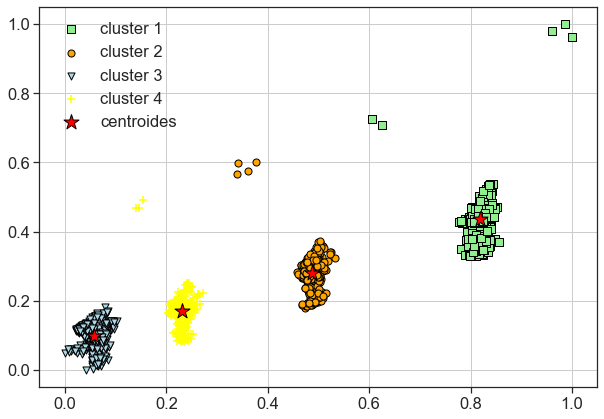

In [48]:
import matplotlib.pyplot as plt

#configuro el tamaño del grafico final
plt.figure(figsize=(10,7))

#scatter del primer cluster
plt.scatter(
    df_train_scaled[y_km == 0, 0], df_train_scaled[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)
#scatter del segundo cluster
plt.scatter(
    df_train_scaled[y_km == 1, 0], df_train_scaled[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)
#scatter del tercer cluster
plt.scatter(
    df_train_scaled[y_km == 2, 0], df_train_scaled[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

#scatter del tercer cluster
plt.scatter(
    df_train_scaled[y_km == 3, 0], df_train_scaled[y_km == 3, 1],
    s=50, c='yellow',
    marker='+',
    label='cluster 4'
)

#scatter del los centroides
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroides'
)
#le pongo la leyenda
plt.legend(scatterpoints=1)
#hace una grilla en el grafico
plt.grid()
#lo imprime en pantalla
plt.show()

C:\Users\MaxiT\.conda\envs\MAXI\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


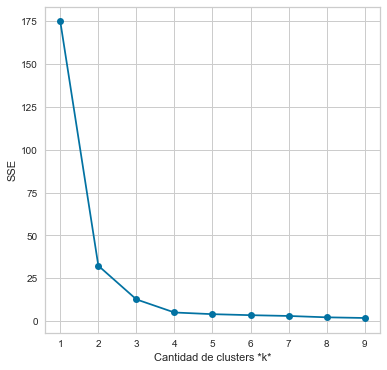

In [55]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_train_scaled)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');

In [51]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 5))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_train_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df_train_scaled, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.7488661259163575
For n_clusters =3 silhouette score is 0.7604211239239285
For n_clusters =4 silhouette score is 0.7702409298410225


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=0))

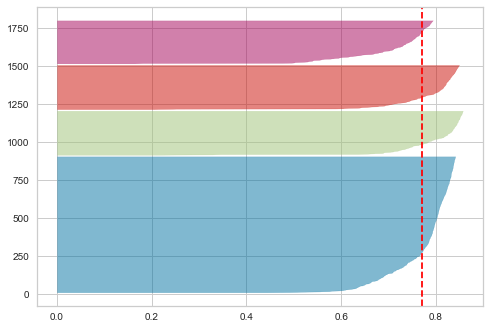

In [53]:
from yellowbrick.cluster import SilhouetteVisualizer

# Genero un modelo con K=3
model = KMeans(4, random_state=0)

# Ploteo el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(df_train_scaled)                                          # Entreno el visualizador con datos